In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from itertools import combinations
import matplotlib as mpl


In [2]:
# Check the random networks
#fig, axs = plt.subplots(8, 1, sharex=True, sharey=True, figsize=(6, 8))
num_sim = 8
matrix_random = np.ones((num_sim, 256))*np.nan
for curr_result in range(num_sim):
    results_dir = './Sim{}/'.format(curr_result+1)
    # Random network activity
    R_rcn_begindelay = np.load(os.path.join(results_dir, 'simulation_results.npz'))['RCN_act_begindelay']
    #mean_activation = np.mean(R_rcn_enddelay, axis=1)
    _mean_activation = np.mean(R_rcn_begindelay, axis=1)
    # reshape to average the three repetitions
    reshape_activation = np.reshape(_mean_activation, (256,3), order='F')
    mean_activation = np.mean(reshape_activation, axis=1)
    matrix_random[curr_result, :]=mean_activation
    if curr_result == 0:
        summary_df = pd.DataFrame(mean_activation, columns=['Mean_act'])
        summary_df['Stimulus'] = range(0, 512, 2)
        summary_df['Sim'] = curr_result+1
    else:
        curr_df = pd.DataFrame(mean_activation, columns=['Mean_act'])
        curr_df['Stimulus'] = range(0, 512, 2)
        curr_df['Sim'] = curr_result+1
        summary_df = pd.concat([summary_df, curr_df]).reset_index(drop=True)
summary_df['Network'] = 'Random'
corr_random = stats.spearmanr(matrix_random.T)[0]

In [14]:
# Check the sensory networks
matrix_sensory = np.ones((num_sim, 256))*np.nan

for curr_result in range(num_sim):
    results_dir = './Sim{}/'.format(curr_result+1)
    # Random network activity
    Sensory_begindelay = np.load(os.path.join(results_dir, 'simulation_results.npz'))['Sensory_act_begindelay']
    #mean_activation = np.mean(Sensory_enddelay[:, :512], axis=1)

    _mean_activation = np.mean(Sensory_begindelay, axis=1)
    # reshape to average the three repetitions
    reshape_activation = np.reshape(_mean_activation, (256,3), order='F')
    mean_activation = np.mean(reshape_activation, axis=1)
    matrix_sensory[curr_result, :] = mean_activation
    curr_df = pd.DataFrame(mean_activation, columns=['Mean_act'])
    curr_df['Stimulus'] = range(0, 512, 2)
    curr_df['Sim'] = curr_result+1
    curr_df['Network'] = 'Sensory'
    summary_df = pd.concat([summary_df, curr_df]).reset_index(drop=True)
corr_sensory = stats.spearmanr(matrix_sensory.T)[0]

In [4]:
ones_mat = np.ones(corr_sensory.shape, dtype=bool)
triu_bool = np.triu(ones_mat, k=1)

In [5]:
pairs = np.where(triu_bool)
pairs_list = []
for curr_pair in range(len(pairs[0])):
    pairs_list.append('{}-{}'.format(pairs[0][curr_pair]+1, 
                                    pairs[1][curr_pair]+1))

In [6]:
corr_random_df = pd.DataFrame(corr_random[triu_bool], columns=['correlation'])
corr_random_df['pairs'] = pairs_list
corr_random_df['Network'] = 'Random'


In [7]:
corr_sensory_df = pd.DataFrame(corr_sensory[triu_bool], columns=['correlation'])
corr_sensory_df['pairs'] = pairs_list
corr_sensory_df['Network'] = 'Sensory'

In [8]:
# Correlation summary
corr_df = pd.concat([corr_random_df, corr_sensory_df]).reset_index(drop=True)

/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

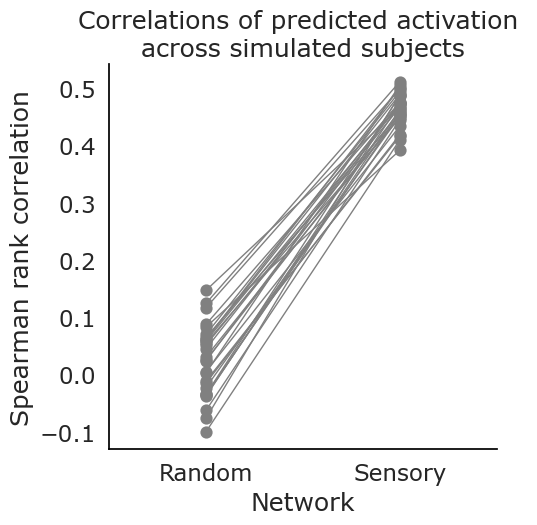

In [34]:
plt.figure(figsize=(5,5))
sns.set(font="Verdana",font_scale=1.5, 
        rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#sns.set_style('white')
ax=sns.pointplot(x='Network', y='correlation', hue='pairs',
              data=corr_df, palette=['gray']*len(pairs_list))
lw = ax.lines[0].get_linewidth() # lw of first line
plt.setp(ax.lines,linewidth=1)
plt.legend([],[], frameon=False)
plt.title("Correlations of predicted activation \nacross simulated subjects")
plt.ylabel("Spearman rank correlation")
sns.despine(top=True, right=True)
plt.savefig('Ind_diff_N{}_univariate.pdf'.format(num_sim), dpi=25)


In [10]:
# RSA results
matrix_random = np.ones((num_sim, 256))*np.nan
rsm_dict = {}
for curr_result in range(num_sim):
    results_dir = './Sim{}/'.format(curr_result+1)
    # Random network activity
    R_rcn_begindelay = np.load(os.path.join(results_dir, 'simulation_results.npz'))['RCN_act_begindelay']
    _mean_pattern = (R_rcn_begindelay[:256, :] + R_rcn_begindelay[256:-256, :] + R_rcn_begindelay[-256:, :])/3
    sim_mat = np.corrcoef(_mean_pattern)
    #mean_activation = np.mean(reshape_activation, axis=1)
    #matrix_random[curr_result, :]=mean_activation
    rsm_dict['{}_{}'.format('Random', curr_result)] = sim_mat 

for curr_result in range(num_sim):
    results_dir = './Sim{}/'.format(curr_result+1)
    # Random network activity
    Sensory_begindelay = np.load(os.path.join(results_dir, 'simulation_results.npz'))['Sensory_act_begindelay']
    _mean_pattern = (Sensory_begindelay[:256, :] + Sensory_begindelay[256:-256, :] + Sensory_begindelay[-256:, :])/3
    sim_mat = np.corrcoef(_mean_pattern)
    rsm_dict['{}_{}'.format('Sensory', curr_result)] = sim_mat 

roi_list = ['Random', 'Sensory']
triu_mat = np.ones((256, 256), dtype=bool)
triu_mat = np.triu(triu_mat, k=1)
summary_df_rsa = pd.DataFrame(columns=['Network', 'Pair', 'Rank corr'])
for curr_roi in roi_list:
    for curr_pair in combinations(range(num_sim), 2):
        curr_sim_1_vect = rsm_dict['{}_{}'.format(curr_roi, curr_pair[0])][triu_mat]
        curr_sim_2_vect = rsm_dict['{}_{}'.format(curr_roi, curr_pair[1])][triu_mat]
        summary_df_rsa.loc[len(summary_df_rsa)] = {'Network': curr_roi, 
                                                   'Pair': '{}-{}'.format(curr_pair[0], curr_pair[1]), 
                                                   'Rank corr': stats.spearmanr(curr_sim_1_vect, curr_sim_2_vect)[0]}

/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

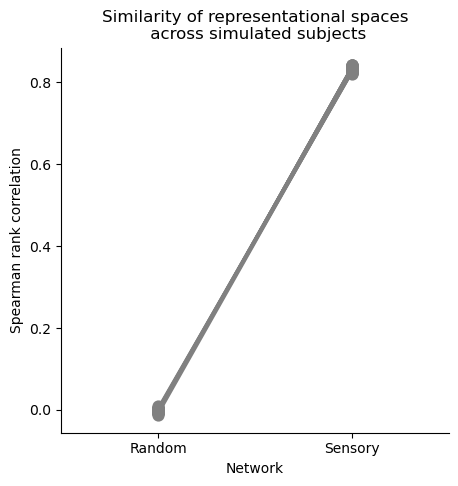

In [11]:
# sns.set(font_scale=1.5)
# sns.set_style('white')
plt.figure(figsize=(5,5))
ax=sns.pointplot(x='Network', y='Rank corr', hue='Pair', data=summary_df_rsa, palette=['gray']*len(pairs_list))
plt.legend([],[], frameon=False)
plt.title("Similarity of representational spaces\n across simulated subjects")
plt.ylabel("Spearman rank correlation")
lw = ax.lines[0].get_linewidth() # lw of first line
plt.setp(ax.lines,linewidth=1)
sns.despine(top=True, right=True)
#plt.savefig('Ind_diff_N{}_RSA.pdf'.format(num_sim), dpi=25)

In [12]:
# Within-subject RSA
summary_df_rsa_within = pd.DataFrame(columns=['Sub', 'Rank corr'])
for curr_sub in range(num_sim):
    curr_sim_1_vect = rsm_dict['{}_{}'.format('Random', curr_sub)][triu_mat]
    curr_sim_2_vect = rsm_dict['{}_{}'.format('Sensory', curr_sub)][triu_mat]
    summary_df_rsa_within.loc[len(summary_df_rsa_within)] = {'Sub': curr_sub, 
                                               'Rank corr': stats.spearmanr(curr_sim_1_vect, curr_sim_2_vect)[0]}

In [13]:
summary_df_rsa_within

,Sub,Rank corr
0,0,-0.005361
1,1,0.000275
2,2,-0.001996
3,3,-0.001225
4,4,-0.000128
5,5,0.006038
6,6,-0.004150
7,7,-0.001845


In [121]:
across_roi = np.corrcoef(matrix_random, matrix_sensory)[:5, 5:]

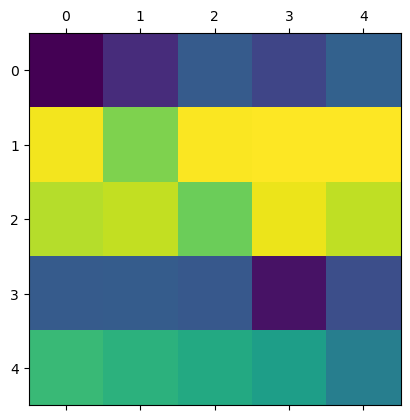

In [123]:
plt.matshow(across_roi)

In [124]:
within_sub_df = pd.DataFrame(np.diag(across_roi), columns=['Correlation'])

In [125]:
within_sub_df['Simulation'] = range(1, 6)

/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

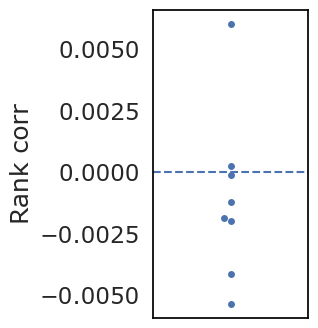

In [46]:
plt.figure(figsize=(2,4))
ax = sns.swarmplot(y='Rank corr', data=summary_df_rsa_within)
ax.axhline(0, ls='--')
#plt.title("'Within-subject' correlation of the mean responses in the two networks")

In [100]:
merged_df = corr_random_df.merge(corr_sensory_df, on='pairs')

In [101]:
merged_df

,correlation_x,pairs,Network_x,correlation_y,Network_y
0,0.218920,1-2,Random,0.113591,Sensory
1,0.120067,1-3,Random,0.141838,Sensory
2,-0.001976,1-4,Random,0.057010,Sensory
3,-0.070764,1-5,Random,-0.080277,Sensory
4,0.012235,2-3,Random,0.080519,Sensory
5,-0.023232,2-4,Random,-0.023041,Sensory
6,-0.078829,2-5,Random,0.022230,Sensory
7,0.030790,3-4,Random,-0.058820,Sensory
8,-0.108864,3-5,Random,0.009213,Sensory
9,0.024968,4-5,Random,-0.024567,Sensory


In [102]:
stats.spearmanr(merged_df['correlation_x'],
               merged_df['correlation_y'])

SignificanceResult(statistic=0.406060606060606, pvalue=0.24428229408662638)

/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qilin/miniforge3/envs/FlexWM/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

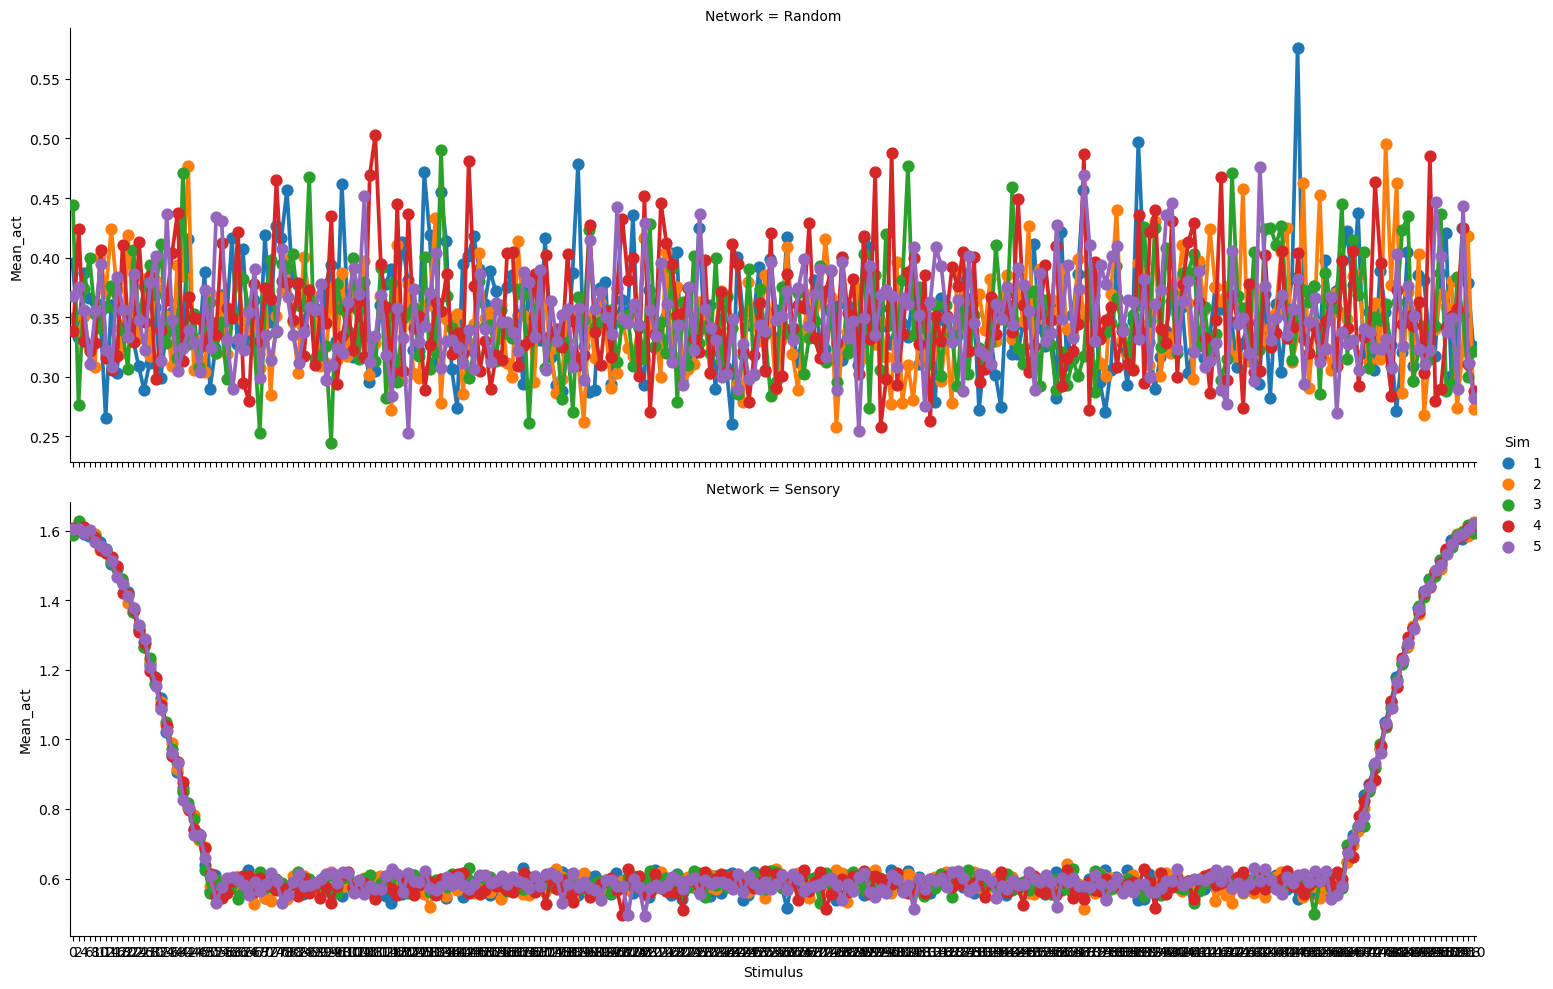

In [117]:
sns.catplot(row='Network', hue='Sim', x='Stimulus', y='Mean_act', kind='point',dodge=True, sharey=False,aspect=3,
            data=summary_df)

In [56]:
results_dir = './Sim2/'

In [57]:
tuning_results = np.load(os.path.join(results_dir, 'Matrix_tuning.npz'))['Matrix_tuning']

row -> neuron, column -> stimulus

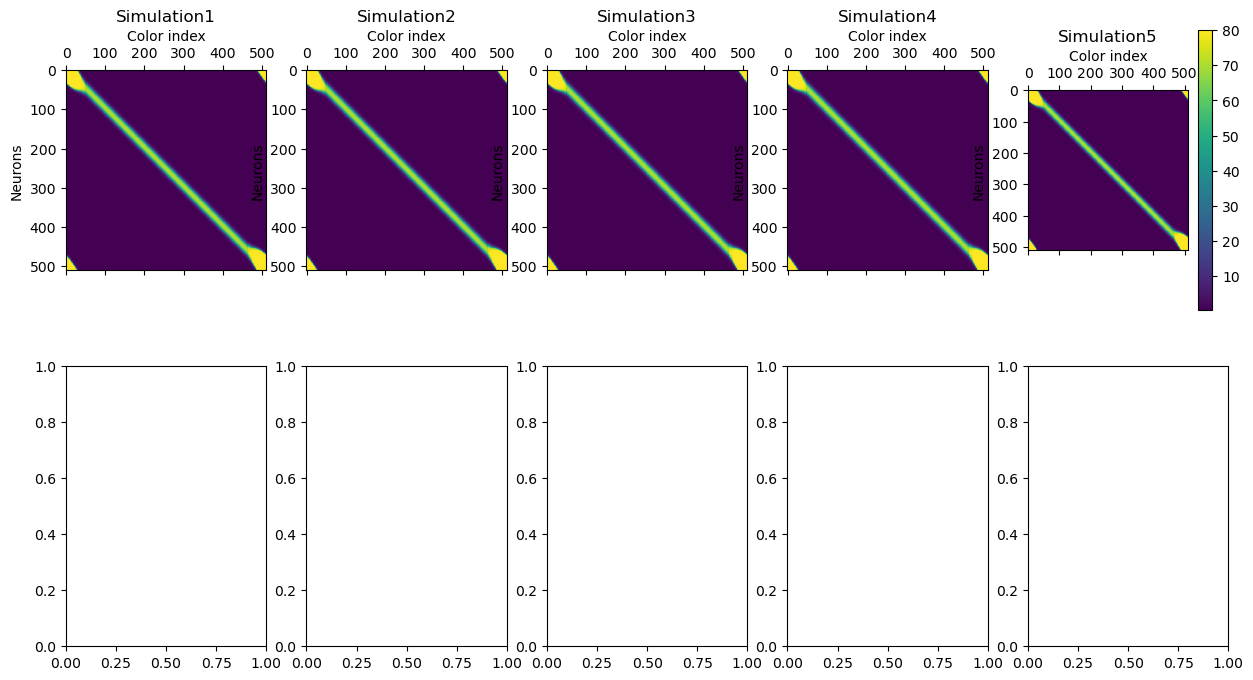

In [119]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
num_sim = 5
for curr_result in range(num_sim):
    results_dir = './Sim{}/'.format(curr_result+1)
    tuning_results = np.load(os.path.join(results_dir, 'Matrix_tuning.npz'))['Matrix_tuning']
    im = axes[int(np.floor(curr_result/5)), curr_result%5].matshow(tuning_results)
    
    axes[int(np.floor(curr_result/5)), curr_result%5].set_ylabel('Neurons')
    axes[int(np.floor(curr_result/5)), curr_result%5].set_xlabel('Color index')
    axes[int(np.floor(curr_result/5)), curr_result%5].set_title('Simulation{}'.format(curr_result+1))
    axes[int(np.floor(curr_result/5)), curr_result%5].xaxis.set_label_position('top') 
fig.colorbar(im)

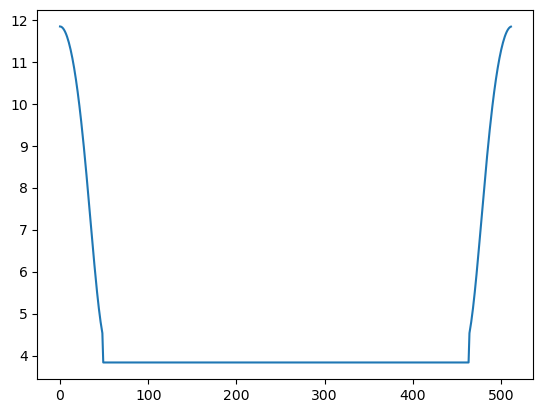

In [24]:
plt.plot(range(512), np.mean(tuning_results, axis=0))

In [11]:
input_matrix = np.load(os.path.join(results_dir, 'simulation_results.npz'))['Matrix_initial_input']

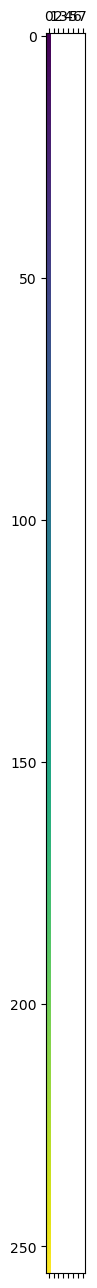

In [12]:
ax = plt.matshow(input_matrix)


In [20]:
# Random network activity
R_rcn_enddelay = np.load(os.path.join(results_dir, 'simulation_results.npz'))['RCN_act_enddelay']

In [22]:
R_rcn_enddelay.shape

(256, 1024)

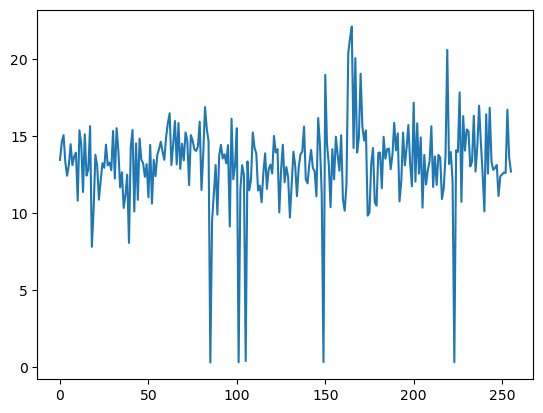

In [23]:
plt.plot(range(256), np.mean(R_rcn_enddelay, axis=1))

In [17]:
Matrix_abs_all = np.load(os.path.join(results_dir, 'simulation_results.npz'))['Matrix_abs_all']

In [18]:
Matrix_abs_all.shape

(256, 8)

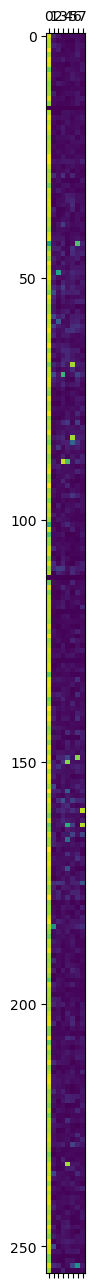

In [19]:
plt.matshow(Matrix_abs_all)